<a href="https://colab.research.google.com/github/chipsalliance/silicon-notebooks/blob/main/xls-workshop-openlane-ja.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# XLSとOpenLaneを使ったコードからの半導体設計

```
Copyright 2021 Google LLC.
SPDX-License-Identifier: Apache-2.0
```
このノートブックでは
- 高位合成ツールキットの[XLS](https://google.github.io/xls/)での設計
- [OpenLane](https://github.com/The-OpenROAD-Project/OpenLane/)による、RTLからGDSの生成
- オープンソースの[SKY130](https://github.com/google/skywater-pdk/) PDK向けのチップ設計

を取り扱います。ソフトウェア開発に近い形でのハードウェア設計を体験してみましょう。

## セットアップ

In [1]:
%pip install -q https://github.com/conda-incubator/condacolab/archive/28521d7c5c494dd6377bb072d97592e30c44609c.tar.gz
#@title conda環境のインストール {display-mode: "form"}
#@markdown - ▷ ボタンをクリックすると、conda-edaのセットアップが開始されます。
#@markdown - インストールが完了するまで、しばらく時間がかかります。
#@markdown - 完了したら、末尾に表示される`Restart Kernel`ボタンをクリックしてください。
import condacolab
condacolab.install_from_url('https://github.com/proppy/conda-eda/releases/download/v0.0-1358-g4ea08b3/openlane-sky130a-0-Linux-x86_64.sh', restart_kernel=False)

     - 35 kB 2.7 MB/s
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
⏬ Downloading https://github.com/proppy/conda-eda/releases/download/v0.0-1358-g4ea08b3/openlane-sky130a-0-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:01:26
🔁 Please restart kernel...


Button(description='Restart kernel now...', style=ButtonStyle())

Output(layout=Layout(border='1px solid black'))

### 追加の依存ライブラリのインストール

- 注：　カーネルの再起動が完了するまでは(`Kernel restarted!`と表示されるまで)、次のインストールを進めないでください。
- ▷ボタンをクリックしてインストールを開始してください。(非表示のセルでインストールが行われます) 

In [1]:
!curl --silent -L -O https://patch-diff.githubusercontent.com/raw/The-OpenROAD-Project/OpenLane/pull/1388.patch
!test -f openlane-patched || patch -d /usr/local/share/openlane -p1 < /content/1388.patch ; touch openlane-patched

patching file flow.tcl
patching file run_issue_regressions.py
patching file scripts/tcl_commands/all.tcl
patching file scripts/tcl_commands/eco.tcl
patching file scripts/tcl_commands/floorplan.tcl
patching file scripts/tcl_commands/klayout.tcl
patching file scripts/tcl_commands/lvs.tcl
patching file scripts/tcl_commands/routing.tcl
patching file scripts/utils/utils.tcl
patching file tests/1007/interactive.tcl
patching file tests/892/hooks/post_run.py
patching file flow.tcl
patching file run_issue_regressions.py
patching file scripts/tcl_commands/all.tcl
patching file scripts/tcl_commands/eco.tcl
patching file scripts/tcl_commands/floorplan.tcl
patching file scripts/tcl_commands/klayout.tcl
patching file scripts/tcl_commands/lvs.tcl
patching file scripts/tcl_commands/routing.tcl
patching file scripts/utils/utils.tcl
patching file tests/1007/interactive.tcl
patching file tests/892/hooks/post_run.py
patching file dependencies/tool_metadata.yml
patching file tests/1007/in.def
File tests/10

In [2]:
!curl --silent -L -O https://patch-diff.githubusercontent.com/raw/The-OpenROAD-Project/OpenLane/pull/1388.patch
!test -f openlane-patched || patch -d /usr/local/share/openlane -p1 < /content/1388.patch ; touch openlane-patched
!curl -L -O https://github.com/google/xls/archive/refs/heads/main.tar.gz
!tar --strip-components=1 -xvf main.tar.gz xls-main/xls/dslx/stdlib/ xls-main/xls/modules/
!sed -ie 's/666/32/' xls/modules/fp/apfloat_add_2.x

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 15.4M    0 15.4M    0     0  8929k      0 --:--:--  0:00:01 --:--:-- 11.5M
xls-main/xls/dslx/stdlib/
xls-main/xls/dslx/stdlib/BUILD
xls-main/xls/dslx/stdlib/acm_random.x
xls-main/xls/dslx/stdlib/apfloat.x
xls-main/xls/dslx/stdlib/bfloat16.x
xls-main/xls/dslx/stdlib/float32.x
xls-main/xls/dslx/stdlib/float32_test.cc
xls-main/xls/dslx/stdlib/float64.x
xls-main/xls/dslx/stdlib/std.x
xls-main/xls/modules/
xls-main/xls/modules/aes/
xls-main/xls/modules/aes/BUILD
xls-main/xls/modules/aes/aes.x
xls-main/xls/modules/aes/aes_common.x
xls-main/xls/modules/aes/aes_ctr.x
xls-main/xls/modules/aes/aes_ctr_test.cc
xls-main/xls/modules/aes/aes_gcm.x
xls-main/xls/modules/aes/aes_gcm_test.cc
xls-main/xls/modules/aes/aes_test.cc
xls-main/xls/modules/aes/aes_test_commo

In [3]:
%%writefile def2gds.mag
gds read $::env(CONDA_PREFIX)/share/pdk/sky130A/libs.ref/sky130_fd_sc_hd/gds/sky130_fd_sc_hd.gds
lef read $::env(CONDA_PREFIX)/share/pdk/sky130A/libs.ref/sky130_fd_sc_hd/techlef/sky130_fd_sc_hd__nom.tlef
lef read $::env(CONDA_PREFIX)/share/pdk/sky130A/libs.ref/sky130_fd_sc_hd/lef/sky130_fd_sc_hd.lef
def read $::env(IN_DEF)
gds write $::env(IN_DEF).gds

Writing def2gds.mag


In [4]:
!git clone https://github.com/mbalestrini/GDS2glTF.git
!python -m pip install -r GDS2glTF/requirements.txt
!git clone https://github.com/proppy/gds_viewer.git

import jinja2
gds_viewer = jinja2.Environment(loader=jinja2.FileSystemLoader('gds_viewer')).get_template('viewer.html') 

import condacolab
CONDA_PREFIX=condacolab.PREFIX
%env CONDA_PREFIX={CONDA_PREFIX}

Cloning into 'GDS2glTF'...
remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 12 (delta 2), reused 8 (delta 2), pack-reused 0
Unpacking objects: 100% (12/12), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 66.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.7/157.7 kB 16.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 60.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.0/40.0 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.8/48.8 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.2/75.2 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 kB 4.8 MB/s eta 0:00:0

In [5]:
import jinja2
gds_viewer = jinja2.Environment(loader=jinja2.FileSystemLoader('gds_viewer')).get_template('viewer.html') 

In [6]:
import condacolab
CONDA_PREFIX=condacolab.PREFIX
%env CONDA_PREFIX={CONDA_PREFIX}

env: CONDA_PREFIX=/usr/local


## 高位合成(HLS)を使った設計

[XLS](https://google.github.io/xls/)は高位合成(High Level Synthesis: HLS)のツールチェインを提供します。XLSを用いることで、ソフトウェア開発に近い方法でハードウェアの設計が可能です。

[DSLX](https://google.github.io/xls/dslx_reference/) はハードウェア設計向けのデータフロー志向・関数型のドメイン特化言語(Domain Specific Language: DSL)です。DSLXで記述した高レベルな機能の設計から、具体的なハードウェアデザインを生成できます。

![img](https://google.github.io/xls/images/xls_stack_diagram.png)

### DSLX

以下の例を通して次のようなDSLXの機能を紹介します。
- 基本的な言語仕様と[文法](https://google.github.io/xls/dslx_reference/#expressions)
- [ユニットテスト](https://google.github.io/xls/dslx_reference/#unit-tests)
- [パラメトリックな関数](https://google.github.io/xls/dslx_reference/#parametric-functions)の定義
- [標準ライブラリ](https://google.github.io/xls/dslx_std/)とモジュールの[インポート](https://google.github.io/xls/dslx_reference/#imports).


In [7]:
%%bash -c 'cat > code.x; interpreter_main code.x'

fn adder<N: u32, N_PLUS_ONE: u32 = N + u32:1>(a: uN[N], b: uN[N]) -> uN[N_PLUS_ONE] {
  let n = a as uN[N_PLUS_ONE] + b as uN[N_PLUS_ONE];
  n
}

fn adder1(a: u1, b: u1) -> u2 {
  adder<u32:1>(a, b)
}

fn adder2(a: u2, b: u2) -> u3 {
  adder<u32:2>(a, b)
}

fn adder4(a: u4, b: u4) -> u5 {
  adder<u32:4>(a, b)
}

#[test]
fn adder_test() {
  let _= assert_eq(adder1(u1:1, u1:1), u2:2);
  let _= assert_eq(adder2(u2:3, u2:1), u3:4);
  let _= assert_eq(adder4(u4:15, u4:1), u5:16);
  _
}

fn popcount(n: u8) -> u8 {
  for (i, c): (u8, u8) in u8:0..u8:8 {
    c + ((n >> i) & u8:1)
  }(u8:0)
}

#[test]
fn popcount_test() {
  let _= assert_eq(popcount(u8:0b0000_0000), u8:0);
  let _= assert_eq(popcount(u8:0b0000_0001), u8:1);
  let _= assert_eq(popcount(u8:0b1111_0000), u8:4);
  let _= assert_eq(popcount(u8:0b0101_0101), u8:4);
  let _= assert_eq(popcount(u8:0b1111_1111), u8:8);
  _
}

import xls.modules.fp.apfloat_add_2
import apfloat
type F8 = apfloat::APFloat<u32:4, u32:3>;

fn fadder8(a: F8, b: F8) -> F8 {
  apfloat_add_2::add(a, b)
}

#[test]
fn fadder8_test() {
  let _= assert_eq(fadder8(apfloat::cast_from_fixed<u32:4, u32:3>(s8:1),
                           apfloat::cast_from_fixed<u32:4, u32:3>(s8:1)),
                   apfloat::cast_from_fixed<u32:4, u32:3>(s32:2));
  _
}


[ RUN UNITTEST  ] adder_test
[            OK ]
[ RUN UNITTEST  ] popcount_test
[            OK ]
[ RUN UNITTEST  ] fadder8_test
libunwind: __unw_add_dynamic_fde: bad fde: FDE is really a CIE
[            OK ]
[===============] 3 test(s) ran; 0 failed; 0 skipped.


In [8]:
#@title 使用するデザイン(機能)の選択{ run: "auto" }
#@markdown - この先のフローで試すデザイン(関数)を選択してください。 (adder: 符号なし整数の加算器、popcount: 8ビットカウンター、fadder: 浮動小数点加算器)

DESIGN = 'adder1' #@param ["adder1", "adder2", "adder4", "popcount", "fadder8"]
%env DESIGN={DESIGN}

env: DESIGN=adder1


## ハードウェアIRへの変換
DSLXのコードからハードウェア回路合成により適した形式
[XLS IR](https://google.github.io/xls/ir_semantics/)に変換しましょう。
XLS IRは回路合成に特化した純粋なデータフロー志向の中間表現(Intermediate Respresentation: IR)です。

In [9]:
!ir_converter_main --top={DESIGN} code.x > {DESIGN}.ir
!opt_main {DESIGN}.ir > {DESIGN}_opt.ir
!cat {DESIGN}_opt.ir

package code

file_number 0 "fake_file.x"

top fn __code__adder1(a: bits[1], b: bits[1]) -> bits[2] {
  literal.17: bits[1] = literal(value=0, id=17, pos=[(0,7,7)])
  literal.21: bits[1] = literal(value=0, id=21, pos=[(0,7,7)])
  concat.18: bits[2] = concat(literal.17, a, id=18, pos=[(0,7,7)])
  concat.19: bits[2] = concat(literal.21, b, id=19, pos=[(0,7,7)])
  ret n: bits[2] = add(concat.18, concat.19, id=20, pos=[(0,2,30)])
}


## RTLの生成

XLS codegenを使うことで、XLS IRから回路合成とシミュレーションに使用する
(System) Verilog [RTL](https://en.wikipedia.org/wiki/Register-transfer_level)を生成できます。

[Verilog](https://en.wikipedia.org/wiki/Verilog)は回路設計で広く用いられているので、XLSで生成されたVerilogコードは、各種の設計フローや他の設計と統合することができます。

In [10]:
!codegen_main --use_system_verilog=false --module_name={DESIGN} --generator=combinational {DESIGN}_opt.ir > {DESIGN}.v
!cat {DESIGN}.v

module adder1(
  input wire a,
  input wire b,
  output wire [1:0] out
);
  wire [1:0] n;
  assign n = {1'h0, a} + {1'h0, b};
  assign out = n;
endmodule


## OpenLaneフローの実行

[OpenLane](https://openlane.readthedocs.io/en/latest/)
は[RTL](https://en.wikipedia.org/wiki/Register-transfer_level) 
から
[GDSII](https://en.wikipedia.org/wiki/GDSII)
を生成する自動化されたフローです。

このフローは
[OpenROAD](https://theopenroadproject.org/), 
[Yosys](https://yosyshq.net/yosys/), [Magic](http://www.opencircuitdesign.com/magic/), [Netgen](http://opencircuitdesign.com/netgen/)
といったコンポーネントと
[open source PDKs](https://github.com/google/open-source-pdks)向けのデザイン探索や最適化のためのカスタムスクリプトからなります。

フローの概要については下記の図を参考にしてください。

![img](https://openlane.readthedocs.io/en/latest/_images/flow_v1.png)

#### OpenLaneの設定

[ドキュメント](https://openlane.readthedocs.io/en/latest/reference/configuration.html)

In [11]:
%%writefile config.tcl
set ::env(DESIGN_NAME) $::env(DESIGN)

set ::env(VERILOG_FILES) "$::env(DESIGN).v"

set ::env(CLOCK_TREE_SYNTH) 0
set ::env(CLOCK_PORT) ""
set ::env(CLOCK_PERIOD) 100

set ::env(FP_SIZING) absolute
set ::env(DIE_AREA) "0 0 50 50"
set ::env(PL_TARGET_DENSITY) 0.30

Writing config.tcl


### 回路合成

- 入力: [RTL](https://en.wikipedia.org/wiki/Register-transfer_level) (Verilog)
- 出力: 素子情報付きの[ネットリスト](https://en.wikipedia.org/wiki/Netlist) (Verilog)
- メトリック: セルの数と [タイミング収束](https://en.wikipedia.org/wiki/Timing_closure) の推定値

[ドキュメント](https://openlane.readthedocs.io/en/latest/usage/hardening_macros.html#synthesis)

In [12]:
!flow.tcl -design . -to synthesis

OpenLane UNKNOWN
(with mounted scripts from fatal: not a git repository: '/usr/local/share/openlane/.git')
All rights reserved. (c) 2020-2022 Efabless Corporation and contributors.
Available under the Apache License, version 2.0. See the LICENSE file for more details.

[WARNING]: OpenLane may not function properly: not enough values to unpack (expected 3, got 1)
The version of open_pdks used in building the PDK does not match the version OpenLane was tested on (installed: 41e2da101560ea1b890dd9f34f6b5adec5016eea, tested: 8f6aff1881e5feae49acb6d5be53c4acc91bb235)
This may introduce some issues. You may want to re-install the PDK by invoking `make pdk`.
The version of magic used in building the PDK does not match the version OpenLane was tested on (installed: f12a155ea72d72218913ea989159da1bec587be2, tested: 7905e15ae3b66ed26349fb701b475ef93b566de5)
This may introduce some issues. You may want to re-install the PDK by invoking `make pdk`.
[INFO]: Using configuration in 'config.tcl'...
[I

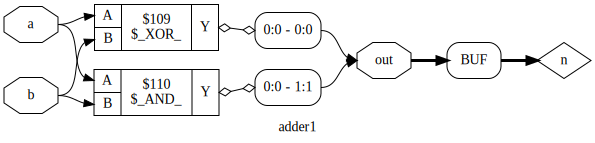

In [13]:
#@title ネットリストのプレビュー {display-mode: "form"}

import graphviz
import pathlib

dots = sorted(pathlib.Path('runs').glob('*/tmp/synthesis/post_techmap.dot'))
dot = graphviz.Source.from_file(dots[-1])
dot.engine = 'dot'
dot

### フロアプラン

- 入力: 素子情報付きの[ネットリスト](https://en.wikipedia.org/wiki/Netlist) (Verilog)
- 出力: 電源供給配線網(Power Delivery Network: PDN)とI/Oピンのついたダイ上のレイアウト([DEF](https://en.wikipedia.org/wiki/Design_Exchange_Format))
- メトリック: コアの面積

[ドキュメント](https://openlane.readthedocs.io/en/latest/usage/hardening_macros.html#floorplan)

In [14]:
!flow.tcl -design . -to floorplan

OpenLane UNKNOWN
(with mounted scripts from fatal: not a git repository: '/usr/local/share/openlane/.git')
All rights reserved. (c) 2020-2022 Efabless Corporation and contributors.
Available under the Apache License, version 2.0. See the LICENSE file for more details.

[WARNING]: OpenLane may not function properly: not enough values to unpack (expected 3, got 1)
The version of open_pdks used in building the PDK does not match the version OpenLane was tested on (installed: 41e2da101560ea1b890dd9f34f6b5adec5016eea, tested: 8f6aff1881e5feae49acb6d5be53c4acc91bb235)
This may introduce some issues. You may want to re-install the PDK by invoking `make pdk`.
The version of magic used in building the PDK does not match the version OpenLane was tested on (installed: f12a155ea72d72218913ea989159da1bec587be2, tested: 7905e15ae3b66ed26349fb701b475ef93b566de5)
This may introduce some issues. You may want to re-install the PDK by invoking `make pdk`.
[INFO]: Using configuration in 'config.tcl'...
[I

In [15]:
#@title プレビュー {display-mode: "form"}

import pathlib

STEP='floorplan'
in_def = sorted(pathlib.Path('runs').glob(f'*/results/{STEP}/*.def'))[-1].resolve()
!IN_DEF={in_def} magic -dnull -noconsole -rcfile {CONDA_PREFIX}/share/pdk/sky130A/libs.tech/magic/sky130A.magicrc < def2gds.mag
!python3 GDS2glTF/gds2gltf.py {in_def}.gds | tee gds2gltf.log
import IPython.display
IPython.display.clear_output(wait=True)
with open(f'{in_def}.gds.gltf') as f:
  gltf_data=f.read()
  output = gds_viewer.render(gltf_data=gltf_data)
IPython.display.HTML(output)

### 配置

- 入力: 素子情報付きの[ネットリスト](https://en.wikipedia.org/wiki/Netlist) (Verilog), 
PDNとI/Oピンつきのダイの物理レイアウト([DEF](https://en.wikipedia.org/wiki/Design_Exchange_Format))
- 出力: コンポーネントのセルが配置された物理レイアウト ([DEF](https://en.wikipedia.org/wiki/Design_Exchange_Format))
- メトリック: コア面積, セル密度, [タイミング収束](https://en.wikipedia.org/wiki/Timing_closure)の推定値

[ドキュメント](https://openlane.readthedocs.io/en/latest/usage/hardening_macros.html#placement)

In [16]:
!flow.tcl -design . -to placement

OpenLane UNKNOWN
(with mounted scripts from fatal: not a git repository: '/usr/local/share/openlane/.git')
All rights reserved. (c) 2020-2022 Efabless Corporation and contributors.
Available under the Apache License, version 2.0. See the LICENSE file for more details.

[WARNING]: OpenLane may not function properly: not enough values to unpack (expected 3, got 1)
The version of open_pdks used in building the PDK does not match the version OpenLane was tested on (installed: 41e2da101560ea1b890dd9f34f6b5adec5016eea, tested: 8f6aff1881e5feae49acb6d5be53c4acc91bb235)
This may introduce some issues. You may want to re-install the PDK by invoking `make pdk`.
The version of magic used in building the PDK does not match the version OpenLane was tested on (installed: f12a155ea72d72218913ea989159da1bec587be2, tested: 7905e15ae3b66ed26349fb701b475ef93b566de5)
This may introduce some issues. You may want to re-install the PDK by invoking `make pdk`.
[INFO]: Using configuration in 'config.tcl'...
[I

In [17]:
#@title プレビュー {display-mode: "form"}

import pathlib

STEP='placement'
in_def = sorted(pathlib.Path('runs').glob(f'*/results/{STEP}/{DESIGN}.def'))[-1].resolve()
!IN_DEF={in_def} magic -dnull -noconsole -rcfile {CONDA_PREFIX}/share/pdk/sky130A/libs.tech/magic/sky130A.magicrc < def2gds.mag
!python3 GDS2glTF/gds2gltf.py {in_def}.gds | tee gds2gltf.log
import IPython.display
IPython.display.clear_output(wait=True)
with open(f'{in_def}.gds.gltf') as f:
  gltf_data=f.read()
  output = gds_viewer.render(gltf_data=gltf_data)
IPython.display.HTML(output)

### 配線

- 入力: 素子情報付きの[ネットリスト](https://en.wikipedia.org/wiki/Netlist) (Verilog), 
コンポーネントのセルが配置された物理レイアウト([DEF](https://en.wikipedia.org/wiki/Design_Exchange_Format))

- 出力: コンポーネントのセルへの配線が完了した物理レイアウト ([DEF](https://en.wikipedia.org/wiki/Design_Exchange_Format))
- メトリック: ルートの衝突, [タイミング収束](https://en.wikipedia.org/wiki/Timing_closure)の予測値

[ドキュメント](https://openlane.readthedocs.io/en/latest/usage/hardening_macros.html#routing)

In [18]:
!flow.tcl -design . -to routing

OpenLane UNKNOWN
(with mounted scripts from fatal: not a git repository: '/usr/local/share/openlane/.git')
All rights reserved. (c) 2020-2022 Efabless Corporation and contributors.
Available under the Apache License, version 2.0. See the LICENSE file for more details.

[WARNING]: OpenLane may not function properly: not enough values to unpack (expected 3, got 1)
The version of open_pdks used in building the PDK does not match the version OpenLane was tested on (installed: 41e2da101560ea1b890dd9f34f6b5adec5016eea, tested: 8f6aff1881e5feae49acb6d5be53c4acc91bb235)
This may introduce some issues. You may want to re-install the PDK by invoking `make pdk`.
The version of magic used in building the PDK does not match the version OpenLane was tested on (installed: f12a155ea72d72218913ea989159da1bec587be2, tested: 7905e15ae3b66ed26349fb701b475ef93b566de5)
This may introduce some issues. You may want to re-install the PDK by invoking `make pdk`.
[INFO]: Using configuration in 'config.tcl'...
[I

In [19]:
#@title プレビュー {display-mode: "form"}

import pathlib

STEP='routing'
in_def = sorted(pathlib.Path('runs').glob(f'*/results/{STEP}/{DESIGN}.def'))[-1].resolve()
!IN_DEF={in_def} magic -dnull -noconsole -rcfile {CONDA_PREFIX}/share/pdk/sky130A/libs.tech/magic/sky130A.magicrc < def2gds.mag
!python3 GDS2glTF/gds2gltf.py {in_def}.gds | tee gds2gltf.log
import IPython.display
IPython.display.clear_output(wait=True)
with open(f'{in_def}.gds.gltf') as f:
  gltf_data=f.read()
  output = gds_viewer.render(gltf_data=gltf_data)
IPython.display.HTML(output)

### サインオフ

- 入力: コンポーネントのセルへの配線が完了した物理レイアウト([DEF](https://en.wikipedia.org/wiki/Design_Exchange_Format))
- 出力: ファウンドリの[DRCルール](https://en.wikipedia.org/wiki/Design_rule_checking)検証済みで製造に出せる物理レイアウト ([GDSII](https://en.wikipedia.org/wiki/GDSII))
- メトリック: DRCエラー, [寄生データ](https://en.wikipedia.org/wiki/Standard_Parasitic_Exchange_Format), [タイミング収束](https://en.wikipedia.org/wiki/Timing_closure)の予測値

[ドキュメント](https://openlane.readthedocs.io/en/latest/usage/hardening_macros.html#final-reports-and-checks)

In [20]:
!flow.tcl -design .

OpenLane UNKNOWN
(with mounted scripts from fatal: not a git repository: '/usr/local/share/openlane/.git')
All rights reserved. (c) 2020-2022 Efabless Corporation and contributors.
Available under the Apache License, version 2.0. See the LICENSE file for more details.

[WARNING]: OpenLane may not function properly: not enough values to unpack (expected 3, got 1)
The version of open_pdks used in building the PDK does not match the version OpenLane was tested on (installed: 41e2da101560ea1b890dd9f34f6b5adec5016eea, tested: 8f6aff1881e5feae49acb6d5be53c4acc91bb235)
This may introduce some issues. You may want to re-install the PDK by invoking `make pdk`.
The version of magic used in building the PDK does not match the version OpenLane was tested on (installed: f12a155ea72d72218913ea989159da1bec587be2, tested: 7905e15ae3b66ed26349fb701b475ef93b566de5)
This may introduce some issues. You may want to re-install the PDK by invoking `make pdk`.
[INFO]: Using configuration in 'config.tcl'...
[I

In [21]:
#@title プレビュー {display-mode: "form"}

import pathlib

gds = sorted(pathlib.Path('runs').glob(f'*/results/final/gds/{DESIGN}.gds'))[-1].resolve()
!python3 GDS2glTF/gds2gltf.py {gds} | tee gds2gltf.log
import IPython.display
IPython.display.clear_output(wait=True)
with open(f'{gds}.gltf') as f:
  gltf_data=f.read()
  output = gds_viewer.render(gltf_data=gltf_data)
IPython.display.HTML(output)

In [22]:
#@title メトリック {display-mode: "form"}
#@markdown [ドキュメント](https://openlane.readthedocs.io/en/latest/reference/datapoint_definitions.html)
import pathlib
import pandas as pd

pd.options.display.max_rows = None
csv = sorted(pathlib.Path('runs').glob('*/reports/metrics.csv'))
df = pd.read_csv(csv[-1])
df.transpose()

,0
design,/content
design_name,adder1
config,RUN_2022.10.05_12.21.38
flow_status,flow completed
total_runtime,0h0m35s0ms
routed_runtime,0h0m21s0ms
(Cell/mm^2)/Core_Util,-2.0
DIEAREA_mm^2,0.0025
CellPer_mm^2,-1
OpenDP_Util,2.86


## テープアウト

Googleのスポンサーする[OpenMPW shuttle program](https://developers.google.com/silicon)に参加するためには、設計したチップデザインを[Caravel SoC harness](https://caravel-harness.readthedocs.io/)と統合する必要があります。

[Caravel User Project](https://caravel-user-project.readthedocs.io/en/latest/)
のテンプレートを使用して、[mpw pre-check](https://github.com/efabless/mpw_precheck)のテストが通ることを確認してください。

![caravel](https://caravel-user-project.readthedocs.io/en/latest/_static/layout.png)

- ユーザープロジェクトの面積: 2920 µm x 3520 µm
- SoC: RISC-V based ([specs](https://caravel-mgmt-soc-litex.readthedocs.io/en/latest/#features))
- I/O ピン: 38 ([pinout](https://caravel-harness.readthedocs.io/en/latest/pinout.html))
- 通信: Wishbone bus and 128 logic analyser pins
